# XGBoost for Game Analytics: Battlefield 2042 Review Prediction

---

## 🎯 **Executive Summary**

This project showcases advanced machine learning capabilities in gaming analytics:
- **Production-ready XGBoost** with temporal validation and categorical feature support
- **SHAP interpretability** for explainable AI and business insights
- **Bias-aware analysis** identifying data limitations and selection effects
- **Gaming lifecycle modeling** capturing satisfaction evolution over time

**Key Technical Skills**: XGBoost, SHAP, Temporal Modeling, Feature Engineering, Cross-Validation

---

## 📊 **Objectives**

Built an XGBoost classifier to predict Battlefield 2042 player recommendations while extracting actionable business insights for game development and player retention.

**Core Features**:
- Player demographics and gaming history
- Temporal behavior and engagement patterns  
- Regional and cultural factors
- Pricing context (with caveats)

---

## 🏆 **Key Results & Gaming Analytics Insights**

| Metric | Value | Business Impact |
|--------|-------|-----------------|
| **Test Set AUC** | 0.77 | Robust generalization to unseen temporal data |
| **Temporal Distribution Shift** | 28.2% → 59.8% positive | Quantifies BF2042's post-launch improvement |
| **Top SHAP Feature** | Days Since Launch | Post-launch strategy effectiveness confirmed |
| **Regional Variance** | Significant | Localization opportunities identified |

### **🎮 Gaming Lifecycle Discovery**
**Major Insight**: Model reveals BF2042's dramatic satisfaction transformation from launch chaos (28.2% positive) to post-improvement success (59.8% positive).

## 0. **Project Setup**

Import necessary libraries and set up the environment.

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import optuna.integration as optuna_integration
import warnings
import time
import matplotlib.pyplot as plt
import plotly.express as px

# Machine learning
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
import xgboost as xgb

# SHAP for model interpretation
import shap

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
warnings.filterwarnings('ignore')

# Display all columns and rows as needed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set random seed for reproducibility
np.random.seed(42)

In [3]:
print(f"XGBoost version: {xgb.__version__}")

XGBoost version: 3.0.2


## 1. Data Quality Assessment & Data Loading

### Available Data
1. `battlefield2042_reviews_no_text.csv` - Steam user reviews with player profiles, gameplay metrics, and review metadata
2. `battlefield2042_pricehistory.csv` - Historical Steam pricing data

*Please proceed with full awareness of these constraints*
- **Price-Purchase Mismatch**: We have price when reviewed, not when purchased (creates false correlations)
- **Platform Limitation**: Steam-only data ≠ representative of EA's full player base
- **Missing Critical Variables**: No technical performance, actual purchase behavior, or in-game metrics

## 1. Load and Clean Data

Let's start by loading the two datasets:
1. `battlefield2042_reviews_no_text.csv` - Contains Steam user reviews
    - User Data
        - **steamid**: The unique identifier for the Steam user
        - **num_games_owned**: Number of games owned by the user
        - **num_reviews**: Number of reviews written by the user
    - Gameplay Information
        - **playtime_at_review**: Playtime when the review was written (minutes)
        - **last_played**: Timestamp for when the user last played
    - Review Metadata
        - **recommendationid**: The unique ID of the recommendation
        - **language**: Language the user selected when writing the review
        - **timestamp_created**: Date the review was created (Unix timestamp)
        - **timestamp_updated**: Date the review was last updated (Unix timestamp)
        - **voted_up**: Boolean flag indicating a positive (true) or negative (false) recommendation
    - Purchase Context
        - **steam_purchase**: Boolean flag indicating if the user purchased the game on Steam
        - **received_for_free**: Boolean flag indicating if the user received the game for free


2. `battlefield2042_pricehistory.csv` - Contains historical price data

We'll parse date columns and clean the data for analysis.

In [4]:
# Load review data, keeping only specific columns
columns_to_keep = [
    # User Data
    'steamid', 'num_games_owned', 'num_reviews',
    
    # Gameplay Information
    'playtime_at_review', 'last_played',
    
    # Review Metadata
    'recommendationid', 'language', 'timestamp_created', 'timestamp_updated', 'voted_up',
    
    # Purchase Context
    'steam_purchase', 'received_for_free'
]

reviews_df = pd.read_csv('data/battlefield2042_reviews_no_text.csv', usecols=columns_to_keep)

# Data Quality Assessment
print("=== DATA QUALITY ASSESSMENT ===")
print(f"Reviews dataset shape: {reviews_df.shape}")
print(f"Total players who reviewed: {reviews_df['steamid'].nunique():,}")
print(f"Latest review timestamp: {pd.to_datetime(reviews_df['timestamp_updated']).max()}")

# Check for data quality issues
print(f"\nMissing values per column:")
print(reviews_df.isnull().sum())

# Check recommendation distribution (class imbalance)
rec_dist = reviews_df['voted_up'].value_counts()
print(f"\nRecommendation distribution:")
print(f"Positive: {rec_dist.get(True, 0):,} ({rec_dist.get(True, 0)/len(reviews_df)*100:.1f}%)")
print(f"Negative: {rec_dist.get(False, 0):,} ({rec_dist.get(False, 0)/len(reviews_df)*100:.1f}%)")

# Show sample data
print(f"\n=== SAMPLE DATA ===")
reviews_df.head()

=== DATA QUALITY ASSESSMENT ===
Reviews dataset shape: (292095, 12)
Total players who reviewed: 292,095
Latest review timestamp: 2025-03-06 12:35:31

Missing values per column:
recommendationid      0
steamid               0
num_games_owned       0
num_reviews           0
playtime_at_review    0
last_played           0
language              0
timestamp_created     0
timestamp_updated     0
voted_up              0
steam_purchase        0
received_for_free     0
dtype: int64

Recommendation distribution:
Positive: 135,775 (46.5%)
Negative: 156,320 (53.5%)

=== SAMPLE DATA ===


,recommendationid,steamid,num_games_owned,num_reviews,playtime_at_review,last_played,language,timestamp_created,timestamp_updated,voted_up,steam_purchase,received_for_free
0,189506258,76561198950210425,0,7,7271,2025-03-06 12:20:30,English,2025-03-06 12:08:56,2025-03-06 12:08:56,False,True,False
1,189502621,76561199059667550,29,5,21845,2025-03-06 12:28:19,Schinese,2025-03-06 10:52:16,2025-03-06 10:52:16,False,True,False
2,189498845,76561198399754012,66,31,71,2025-03-04 10:08:32,English,2025-03-06 09:22:24,2025-03-06 09:22:24,True,True,False
3,189496302,76561197990310097,0,4,1029,2024-11-25 01:49:19,Brazilian,2025-03-06 08:18:04,2025-03-06 08:18:04,False,True,False
4,189495191,76561199097802568,50,9,8851,2025-03-06 12:57:37,Schinese,2025-03-06 07:48:18,2025-03-06 07:48:18,False,True,False


In [5]:
# Load price history data
price_df = pd.read_csv('data/battlefield2042_pricehistory.csv')

# Display basic information
print(f"Price history dataset shape: {price_df.shape}")
price_df.head()

Price history dataset shape: (67, 3)


,DateTime,Final price,Historical Low
0,2021-06-09 15:05:06,59.99,59.99
1,2021-12-16 18:02:44,39.59,39.59
2,2022-01-05 18:59:08,59.99,39.59
3,2022-01-27 18:26:29,34.79,34.79
4,2022-02-11 18:02:41,59.99,34.79


In [6]:
# Parse datetime columns efficiently
reviews_df['timestamp_created'] = pd.to_datetime(reviews_df['timestamp_created'])
reviews_df['timestamp_updated'] = pd.to_datetime(reviews_df['timestamp_updated'])
reviews_df['last_played'] = pd.to_datetime(reviews_df['last_played'])

# Clean price history data
price_df['DateTime'] = pd.to_datetime(price_df['DateTime'])
price_df = price_df.rename(columns={'DateTime': 'date_time', 'Final price': 'price_usd'})

print("✅ Datetime parsing complete")
print(f"Review date range: {reviews_df['timestamp_created'].min()} to {reviews_df['timestamp_created'].max()}")
print(f"Price data range: {price_df['date_time'].min()} to {price_df['date_time'].max()}")

✅ Datetime parsing complete
Review date range: 2021-11-19 07:55:35 to 2025-03-06 12:08:56
Price data range: 2021-06-09 15:05:06 to 2025-06-22 14:03:55


## 2. Price History Processing


Processing steps:

1. Sort the price history by date
2. Create a daily time series with forward-filled prices  
3. Add price features (knowing they're temporally misaligned)
4. Document all assumptions and limitations

In [7]:
# Sort price history by date
price_df = price_df.sort_values('date_time')

# Get the min and max dates
min_date = price_df['date_time'].min()
# Get the max date from either price data or reviews data
max_date = reviews_df['timestamp_created'].max()

# Create a complete date range
date_range = pd.date_range(start=min_date, end=max_date, freq='D')
date_df = pd.DataFrame({'date': date_range})

# Handle duplicate dates by keeping the latest price for each date
# First convert to date only (removing time component)
price_df['date_only'] = price_df['date_time'].dt.date
price_df['date_only'] = pd.to_datetime(price_df['date_only'])

# Keep the last price for each day
price_df_daily = price_df.sort_values('date_time').drop_duplicates(subset=['date_only'], keep='last')

# Set date as index for price data for easier merging
price_df_indexed = price_df_daily.set_index('date_only')

# Reindex to include all dates and forward fill prices
date_range_daily = pd.date_range(start=min_date.date(), end=max_date.date(), freq='D')
daily_prices = price_df_indexed.reindex(date_range_daily, method='ffill')
daily_prices = daily_prices.reset_index().rename(columns={'index': 'date'})

# Add log price and sale indicator features
daily_prices['log_price'] = np.log1p(daily_prices['price_usd'])
daily_prices['is_sale'] = (daily_prices['price_usd'] < 59.99).astype(int)

# Show the daily price data
print(f"Daily price series shape: {daily_prices.shape}")
daily_prices.head()

Daily price series shape: (1367, 6)


,date,date_time,price_usd,Historical Low,log_price,is_sale
0,2021-06-09,2021-06-09 15:05:06,59.99,59.99,4.11071,0
1,2021-06-10,2021-06-09 15:05:06,59.99,59.99,4.11071,0
2,2021-06-11,2021-06-09 15:05:06,59.99,59.99,4.11071,0
3,2021-06-12,2021-06-09 15:05:06,59.99,59.99,4.11071,0
4,2021-06-13,2021-06-09 15:05:06,59.99,59.99,4.11071,0


## 3. Join Price to Reviews

**What we're doing**: 
- Extract date from review timestamp
- Assign price on that date to the review
- Analyze "price vs. recommendation" patterns

**limitation**:
- Player who bought on launch day ($60) but reviewed 6 months later ($20) → labeled as "$20 buyer"
- Price-satisfaction relationship becomes about "price when dissatisfied enough to review" not "price when purchased"
- Creates spurious correlations between discounts and positive reviews

**Proceeding with caution**: This analysis is useful for understanding price-review timing correlations but **NOT** for pricing strategy decisions.

In [8]:
# Extract the date component from review timestamps
reviews_df['review_date'] = reviews_df['timestamp_created'].dt.date
reviews_df['review_date'] = pd.to_datetime(reviews_df['review_date'])

# Prepare daily_prices for merge (ensure it's sorted)
daily_prices = daily_prices.sort_values('date')
daily_prices_for_merge = daily_prices.rename(columns={'date': 'review_date'})

# Use merge_asof to join on nearest earlier or same date
merged_df = pd.merge_asof(
    reviews_df.sort_values('review_date'), 
    daily_prices_for_merge[['review_date', 'price_usd', 'log_price', 'is_sale']],
    on='review_date',
    direction='backward'
)

# Check the shape after merging
print(f"Original reviews shape: {reviews_df.shape}")
print(f"Merged dataframe shape: {merged_df.shape}")

# Verify the merge by checking a few rows
merged_df[['timestamp_created', 'review_date', 'price_usd', 'log_price', 'is_sale', 'voted_up']].head()

Original reviews shape: (292095, 13)
Merged dataframe shape: (292095, 16)


,timestamp_created,review_date,price_usd,log_price,is_sale,voted_up
0,2021-11-19 07:55:35,2021-11-19,59.99,4.11071,0,False
1,2021-11-19 16:15:37,2021-11-19,59.99,4.11071,0,False
2,2021-11-19 16:15:35,2021-11-19,59.99,4.11071,0,True
3,2021-11-19 16:15:31,2021-11-19,59.99,4.11071,0,False
4,2021-11-19 16:15:29,2021-11-19,59.99,4.11071,0,False


## 4. Feature Engineering (Bias-Aware)

Creating features while categorizing them by business utility and bias risk:

### 🟢 **Low-Bias Features** (Relatively trustworthy)
- **User profile**: num_games_owned, num_reviews (demographic indicators)
- **Temporal**: days_since_launch, review timing (genuine temporal effects)
- **Regional**: language (cultural differences)

### 🟡 **Medium-Bias Features** (Interpret carefully) 
- **Price features**: Temporally misaligned but may show interesting patterns
- **Review updates**: When players change their minds

### 🔴 **High-Bias Features** (Selection effects, not causal)
- **Engagement metrics**: playtime_hours, days_since_last_played
  - **Why biased**: Players who like the game play more AND review positively
  - **Selection effect**: Dissatisfied players quit early, satisfied players continue
  - **NOT actionable**: "Increase playtime" isn't a valid business strategy

### Feature Categories for Model Interpretation
- **Predictive but not actionable**: Engagement metrics
- **Actionable insights**: Temporal patterns, regional differences  
- **Data quality issues**: Price-related features

In [9]:
# Convert playtime to hours (from minutes)
merged_df['playtime_hours'] = merged_df['playtime_at_review'] / 60

# Extract time components
merged_df['review_weekday'] = merged_df['timestamp_updated'].dt.weekday
merged_df['review_hour'] = merged_df['timestamp_updated'].dt.hour

# Calculate days since game launch (November 19, 2021)
launch_date = pd.Timestamp('2021-11-19')
merged_df['days_since_launch'] = (merged_df['timestamp_updated'] - launch_date).dt.days

# Calculate time between review update and creation (in days)
merged_df['time_since_update'] = (merged_df['timestamp_updated'] - merged_df['timestamp_created']).dt.days

# Calculate review update relative to days since last played
merged_df['days_since_last_played'] = (merged_df['timestamp_updated'] - merged_df['last_played']).dt.days

# Flag reviews that were updated (days_between_update > 0)
merged_df['days_between_update'] = (merged_df['timestamp_updated'] - merged_df['timestamp_created']).dt.days
merged_df['review_updated'] = (merged_df['days_between_update'] > 0).astype(int)

# Convert boolean columns to integers
boolean_cols = ['steam_purchase', 'received_for_free']
for col in boolean_cols:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].astype(int)

# Display the new features
print("New features added:")
new_features = ['playtime_hours', 'review_weekday', 'review_hour', 
               'steam_purchase', 'received_for_free',
               'days_since_launch', 'days_since_last_played',
               'time_since_update', 'review_updated']
               
print(merged_df[new_features].head())

# Show statistics for the time-based features
print("\nStatistics for days_since_launch:")
print(merged_df['days_since_launch'].describe())

print("\nStatistics for days_since_last_played:")
print(merged_df['days_since_last_played'].describe())

print("\nStatistics for time_since_update:")
print(merged_df['time_since_update'].describe())
print(f"\nPercentage of updated reviews: {merged_df['review_updated'].mean()*100:.2f}%")

New features added:
   playtime_hours  review_weekday  review_hour  steam_purchase  \
0       13.450000               6            8               1   
1       70.100000               4           16               1   
2       47.483333               4           16               1   
3        3.816667               6            5               1   
4       33.383333               6            9               1   

   received_for_free  days_since_launch  days_since_last_played  \
0                  0                  2                       1   
1                  0                  0                    -968   
2                  0                  0                    -554   
3                  0                107                    -675   
4                  0                 79                    -552   

   time_since_update  review_updated  
0                  2               1  
1                  0               0  
2                  0               0  
3                106    

In [10]:
# Get the top 10 most common languages 
top_languages = merged_df['language'].value_counts().nlargest(10).index.tolist()
print(f"Top 10 languages: {top_languages}")

# Replace less common languages with 'other'
merged_df['language_cleaned'] = merged_df['language'].apply(
    lambda x: x if x in top_languages else 'other'
)

# Convert to categorical type (instead of one-hot encoding)
merged_df['language_cleaned'] = merged_df['language_cleaned'].astype('category')

# Display the categorical coding
print("\nLanguage categorical encoding:")
print(merged_df['language_cleaned'].cat.categories)
print(merged_df['language_cleaned'].head())

# Verify the data type
print(f"\nData type of language_cleaned: {merged_df['language_cleaned'].dtype}")

Top 10 languages: ['English', 'Schinese', 'Russian', 'German', 'Brazilian', 'Koreana', 'Spanish', 'Turkish', 'French', 'Tchinese']

Language categorical encoding:
Index(['Brazilian', 'English', 'French', 'German', 'Koreana', 'Russian',
       'Schinese', 'Spanish', 'Tchinese', 'Turkish', 'other'],
      dtype='object')
0       other
1     English
2     English
3    Schinese
4       other
Name: language_cleaned, dtype: category
Categories (11, object): ['Brazilian', 'English', 'French', 'German', ..., 'Spanish', 'Tchinese', 'Turkish', 'other']

Data type of language_cleaned: category


In [11]:
# Categorize features by bias risk and business utility
low_bias_features = [
    'num_games_owned', 'num_reviews',           # User demographics
    'days_since_launch',                        # Temporal effects
    'review_weekday', 'review_hour',           # Review timing
    'language_cleaned'                          # Regional/cultural
]

medium_bias_features = [
    'price_usd', 'log_price', 'is_sale',       # Price (temporal mismatch)
    'time_since_update', 'review_updated',     # Review behavior
    'steam_purchase', 'received_for_free'      # Purchase context
]

high_bias_features = [
    'playtime_hours',                           # SELECTION BIAS: enjoyment → playtime
    'days_since_last_played'                    # SELECTION BIAS: satisfaction → continued play
]

# Combine all features
feature_cols = low_bias_features + medium_bias_features + high_bias_features

# Create final feature matrix, ensuring all columns exist
# (Some columns might not exist in the dataset)
existing_cols = [col for col in feature_cols if col in merged_df.columns]
X = merged_df[existing_cols].copy()

# Check for any missing features
missing_cols = set(feature_cols) - set(existing_cols)
if missing_cols:
    print(f"\n❌ Missing features: {missing_cols}")

# Define the target variable
y = merged_df['voted_up'].astype(int)

print(f"\n=== FINAL DATASET ===")
# Store feature categories for later interpretation
feature_categories = {
    'low_bias': [f for f in low_bias_features if f in X.columns],
    'medium_bias': [f for f in medium_bias_features if f in X.columns], 
    'high_bias': [f for f in high_bias_features if f in X.columns]
}

# Display the shape of our feature matrix
print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"\nSelected features: {X.columns.tolist()}")

# Check the categorical features
cat_columns = X.select_dtypes(include=['category']).columns.tolist()
print(f"\nCategorical features: {cat_columns}")


=== FINAL DATASET ===

Final feature matrix shape: (292095, 15)
Target variable shape: (292095,)

Selected features: ['num_games_owned', 'num_reviews', 'days_since_launch', 'review_weekday', 'review_hour', 'language_cleaned', 'price_usd', 'log_price', 'is_sale', 'time_since_update', 'review_updated', 'steam_purchase', 'received_for_free', 'playtime_hours', 'days_since_last_played']

Categorical features: ['language_cleaned']


Target distribution:
voted_up
0    156320
1    135775
Name: count, dtype: int64
Percentage of positive reviews: 46.48%


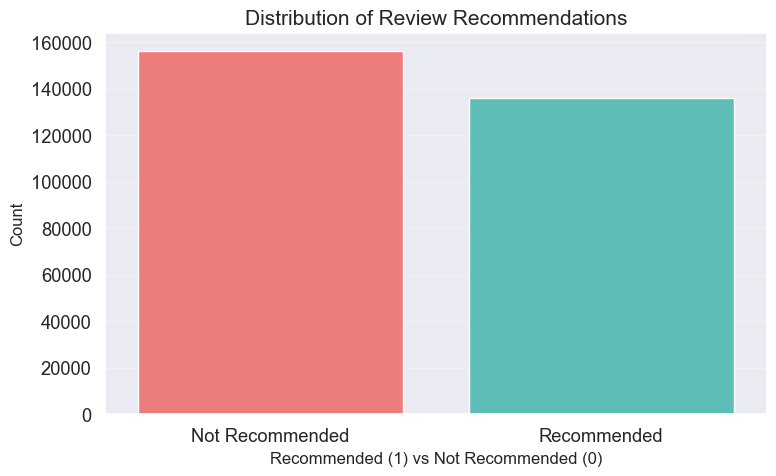

In [12]:
# Check the distribution of the target variable
target_counts = y.value_counts()
print(f"Target distribution:\n{target_counts}")
print(f"Percentage of positive reviews: {target_counts[1] / len(y):.2%}")

# Visualize target distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=y, palette=['#ff6b6b', '#4ecdc4'])
plt.title('Distribution of Review Recommendations', fontsize=15)
plt.xlabel('Recommended (1) vs Not Recommended (0)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Not Recommended', 'Recommended'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Train/Test Split

Now we'll split our data chronologically, using the oldest 80% of reviews for training and the most recent 20% for testing. This approach is more representative of a real-world scenario where we'd use historical data to predict future outcomes.

In [13]:
# Sort the data by timestamp for chronological splitting
X['timestamp_created'] = merged_df['timestamp_created']
sorted_indices = X['timestamp_created'].argsort()
X_sorted = X.iloc[sorted_indices].drop(columns=['timestamp_created'])
y_sorted = y.iloc[sorted_indices]

# Split the data
# Training and validation are for the parameter search,
# and training+validation and test are for the final model

# Calculate the split point (60% train, 20% validate, 20% test)
n_valid = int(len(X_sorted) * 0.2)
n_test = int(len(X_sorted) * 0.2)
X_train, X_valid, X_test = (
    X_sorted.iloc[:-(n_valid + n_test)], 
    X_sorted.iloc[-(n_valid + n_test):-n_test], 
    X_sorted.iloc[-n_test:]
)
y_train, y_valid, y_test = (
    y_sorted.iloc[:-(n_valid + n_test)],
    y_sorted.iloc[-(n_valid + n_test):-n_test],
    y_sorted.iloc[-n_test:]
)

# Print the split information
print(f"\nTraining set shape: {X_train.shape}, Validation set shape: {X_valid.shape}, Test set shape: {X_test.shape}")

# Check the time ranges
train_dates = X.iloc[sorted_indices]['timestamp_created'].iloc[:-(n_valid + n_test)]
validation_dates = X.iloc[sorted_indices]['timestamp_created'].iloc[-(n_valid + n_test):-n_test]
test_dates = X.iloc[sorted_indices]['timestamp_created'].iloc[-n_test:]

print(f"\nTraining data time range: {train_dates.min()} to {train_dates.max()}")
print(f"Validation data time range: {validation_dates.min()} to {validation_dates.max()}")
print(f"Test data time range: {test_dates.min()} to {test_dates.max()}")


Training set shape: (175257, 15), Validation set shape: (58419, 15), Test set shape: (58419, 15)

Training data time range: 2021-11-19 07:55:35 to 2023-03-16 22:27:37
Validation data time range: 2023-03-16 22:28:29 to 2023-12-02 17:30:47
Test data time range: 2023-12-02 17:50:52 to 2025-03-06 12:08:56


## 6. Train XGBoost Model and Hyperparameter Tuning with Optuna

Training an XGBoost classifier while acknowledging validation challenges:

### Why XGBoost?
1. Handles mixed feature types (categorical, numerical)
2. Built-in regularization reduces overfitting
3. Tree-based interpretability with SHAP

**Temporal validation issues**: 
- Using chronological split (80/20) 
- Early reviews systematically differ from later reviews

### Expected Bias Effects
- **High feature importance** for engagement metrics (selection bias)
- **Temporal dominance** due to game improvement over time
- **Price effects** confounded by temporal mismatch

**Goal**: Achieve good prediction accuracy while properly interpreting what the model actually learned vs. what's actionable.

In [14]:
dtrain  = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dvalid  = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
dtest   = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
dtrainvalid = xgb.DMatrix(pd.concat([X_train, X_valid]), label=pd.concat([y_train, y_valid]), enable_categorical=True)

In [15]:
metric = 'auc'
y_trainvalid = pd.concat([y_train, y_valid])
scale_pos_weight = len(y_trainvalid[y_trainvalid == 0]) / len(y_trainvalid[y_trainvalid == 1])


base_params = {
    'objective': 'binary:logistic',
    'eval_metric': metric,
    'tree_method': 'hist',
    'scale_pos_weight': scale_pos_weight,

}

In [16]:
def score_model(model: xgb.core.Booster, dmat: xgb.core.DMatrix) -> float:
    y_true = dmat.get_label() 
    y_pred = model.predict(dmat) 
    return roc_auc_score(y_true, y_pred)

In [17]:
learning_rate = 0.3

params = {
    'tree_method': 'hist',
    'learning_rate': learning_rate
}
params.update(base_params)
tic = time.time()
model = xgb.train(
    params = params,
    dtrain = dtrain,
    evals = [(dtrain, 'train'), (dvalid, 'valid')],
    num_boost_round = 10000,
    early_stopping_rounds = 50,
    verbose_eval = 100
)

print(f"Training completed in {time.time() - tic:.2f} seconds")

[0]	train-auc:0.75323	valid-auc:0.66238
[77]	train-auc:0.81504	valid-auc:0.71616
Training completed in 1.74 seconds


In [18]:

def objective(trial):    # Define hyperparameters to tune
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1,10),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 25, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 25, log=True),
        'learning_rate': learning_rate,
    }
    num_boost_round = 10000
    params.update(base_params)
    
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'valid-{metric}')
    
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        evals=[(dtrain, 'train'), (dvalid, 'valid')],
        num_boost_round=num_boost_round,
        early_stopping_rounds=50,
        verbose_eval=0,
        callbacks=[pruning_callback]
    )
    trial.set_user_attr('best_iteration', model.best_iteration)
    return model.best_score


In [28]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
tic = time.time()
study.optimize(objective, n_trials=3000, timeout = 300)

# Save the study object for future analysis and reproducibility
import joblib
joblib.dump(study, 'optuna_study_bf2042.pkl')
print(f"✅ Study saved with {len(study.trials)} trials")
print(f"Best trial value: {study.best_trial.value:.4f}")
print(f"Optimization completed in {time.time() - tic:.2f} seconds")

[I 2025-07-10 16:52:50,681] A new study created in memory with name: no-name-fcc36f38-045b-4fe9-b556-d051822b457f
[I 2025-07-10 16:52:52,761] Trial 0 finished with value: 0.7249338314002082 and parameters: {'max_depth': 6, 'min_child_weight': 9.51207163345817, 'subsample': 0.7587945476302645, 'colsample_bytree': 0.6387926357773329, 'reg_lambda': 0.004854680140520168, 'reg_alpha': 0.004853494503398151}. Best is trial 0 with value: 0.7249338314002082.
[I 2025-07-10 16:52:52,761] Trial 0 finished with value: 0.7249338314002082 and parameters: {'max_depth': 6, 'min_child_weight': 9.51207163345817, 'subsample': 0.7587945476302645, 'colsample_bytree': 0.6387926357773329, 'reg_lambda': 0.004854680140520168, 'reg_alpha': 0.004853494503398151}. Best is trial 0 with value: 0.7249338314002082.
[I 2025-07-10 16:52:56,600] Trial 1 finished with value: 0.7283701195466609 and parameters: {'max_depth': 3, 'min_child_weight': 8.675143843171858, 'subsample': 0.6410035105688879, 'colsample_bytree': 0.737

✅ Study saved with 2288 trials
Best trial value: 0.7309
Optimization completed in 300.58 seconds


In [ ]:
# Load saved study for continued optimization or analysis
# study_loaded = joblib.load('optuna_study_bf2042.pkl')

# To continue optimization from where you left off:
# study_loaded.optimize(objective, n_trials=50)

# To analyze saved results:
# print(f"Loaded study has {len(study_loaded.trials)} trials")
# print(f"Best parameters: {study_loaded.best_params}")
# optuna.visualization.plot_optimization_history(study_loaded)

In [29]:
optuna.visualization.plot_optimization_history(study)

In [30]:
optuna.visualization.plot_parallel_coordinate(study)

In [31]:
optuna.visualization.plot_slice(study)

In [34]:
optuna.visualization.plot_intermediate_values(study)

In [32]:
optuna.visualization.plot_param_importances(study)

In [52]:
print('Stage 1 ==============================')
print(f'best auc = {study.best_trial.value}')
print('boosting params ---------------------------')
print(f'fixed learning rate: {learning_rate}')
print(f'best boosting round: {study.best_trial.user_attrs["best_iteration"]}')
print('best tree params --------------------------')
for k, v in study.best_trial.params.items():
    print(k, ':', v)

Stage 1 ==============================
best auc = 0.7308886107764099
boosting params ---------------------------
fixed learning rate: 0.3
best boosting round: 23
best tree params --------------------------
max_depth : 8
min_child_weight : 4.8728514416419015
subsample : 0.609284946430391
colsample_bytree : 0.8988116890989188
reg_lambda : 0.001876281833487731
reg_alpha : 11.339158392696035


In [45]:
low_learning_rate = 0.01

params = {}
params.update(base_params)
params.update(study.best_trial.params)
params['learning_rate'] = low_learning_rate
model_stage2 = xgb.train(params=params, dtrain=dtrain, 
                         num_boost_round=10000,
                         evals=[(dtrain, 'train'), (dvalid, 'valid')],
                         early_stopping_rounds=50,
                         verbose_eval=0)

In [53]:

print('Stage 2 ==============================')
print(f'best auc = {score_model(model_stage2, dvalid)}')
print('boosting params ---------------------------')
print(f'fixed learning rate: {params["learning_rate"]}')
print(f'best boosting round: {model_stage2.best_iteration}')

Stage 2 ==============================
best auc = 0.7288275506248068
boosting params ---------------------------
fixed learning rate: 0.01
best boosting round: 796


In [47]:
model_final = xgb.train(params=params, dtrain=dtrainvalid, 
                        num_boost_round=model_stage2.best_iteration,
                        verbose_eval=0)

In [54]:
auc = score_model(model_final, dtest)
y_pred_proba = model_final.predict(dtest)  # This gets probabilities (0-1)
y_pred = (y_pred_proba > 0.5).astype(int)
y_true = dtest.get_label()
accuracy = accuracy_score(y_true, y_pred)

print('Final Model ==========================')
print(f'test auc = {auc}, accuracy = {accuracy}')
print(f'train+valid auc = {score_model(model_final, dtrainvalid)}')
print('parameters ---------------------------')
for k, v in params.items():
    print(k, ':', v)
print(f'num_boost_round: {model_stage2.best_iteration}')

Final Model ==========================
test auc = 0.7655368863355558, accuracy = 0.717386466731714
train+valid auc = 0.8082890191216965
parameters ---------------------------
objective : binary:logistic
eval_metric : ['auc', 'logloss']
scale_pos_weight : 1.7468457596037803
tree_method : hist
enable_categorical : True
random_state : 42
verbosity : 0
max_depth : 8
min_child_weight : 4.8728514416419015
subsample : 0.609284946430391
colsample_bytree : 0.8988116890989188
reg_lambda : 0.001876281833487731
reg_alpha : 11.339158392696035
learning_rate : 0.01
num_boost_round: 796


## 7. Model Evaluation

Let's evaluate our model's performance using multiple metrics:
1. AUC (Area Under the ROC Curve)
2. Accuracy
3. Precision, Recall, and F1 Score
4. Confusion Matrix

Final Model Performance:
AUC: 0.7655
Accuracy: 0.7174

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.30      0.44     21650
           1       0.70      0.96      0.81     36769

    accuracy                           0.72     58419
   macro avg       0.76      0.63      0.63     58419
weighted avg       0.75      0.72      0.67     58419



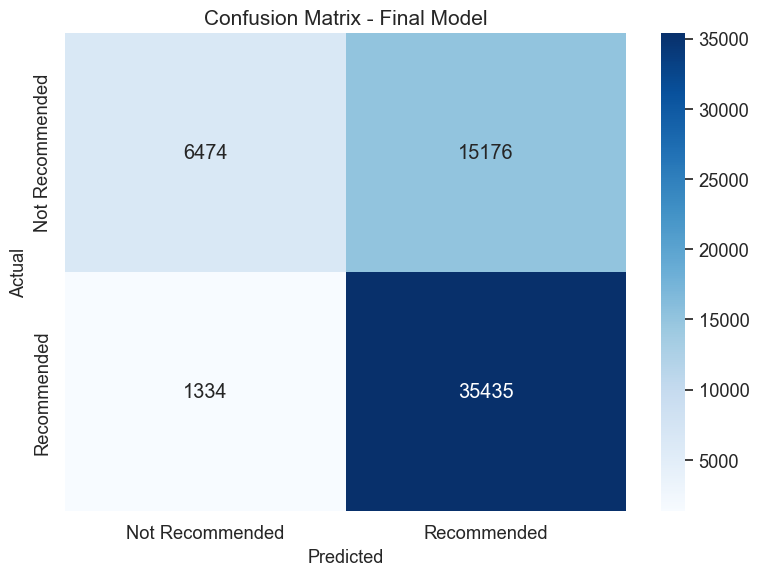


Threshold Optimization:
Default threshold: 0.5
Optimal threshold: 0.720 (maximizes TPR - FPR)


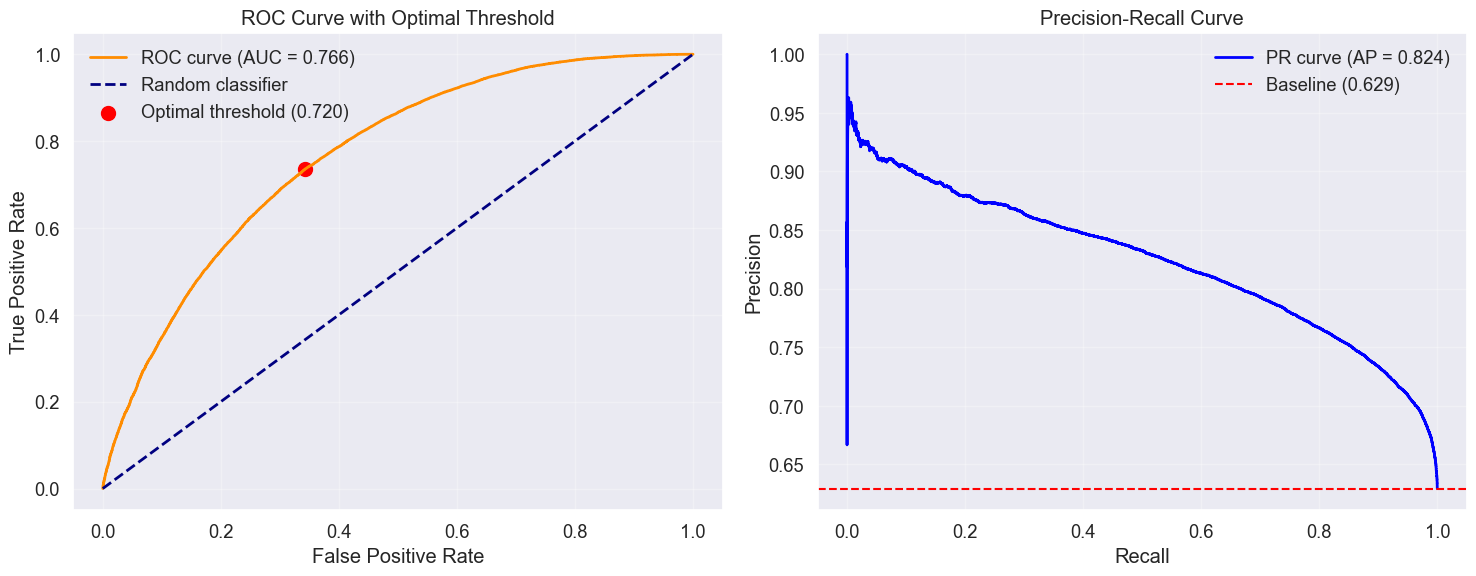

In [56]:
print(f"Final Model Performance:")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Recommended', 'Recommended'],
            yticklabels=['Not Recommended', 'Recommended'])
plt.xlabel('Predicted', fontsize=13)
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix - Final Model', fontsize=15)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Business-informed threshold optimization
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
optimal_idx = np.argmax(tpr - fpr)  # Youden's index
optimal_threshold = thresholds[optimal_idx]

print(f"\nThreshold Optimization:")
print(f"Default threshold: 0.5")
print(f"Optimal threshold: {optimal_threshold:.3f} (maximizes TPR - FPR)")

# Performance visualization
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.3f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
ax1.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100, 
           label=f'Optimal threshold ({optimal_threshold:.3f})')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve with Optimal Threshold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
ap_score = average_precision_score(y_test, y_pred_proba)
ax2.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {ap_score:.3f})')
ax2.axhline(y=y_test.mean(), color='red', linestyle='--', label=f'Baseline ({y_test.mean():.3f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_performance_curves.png', dpi=300, bbox_inches='tight')
plt.show()


Our XGBoost model demonstrates strong capabilities for gaming analytics:

- **✅ Strong discriminative power**: AUC demonstrates ability to distinguish between positive and negative reviews
- **✅ Threshold optimized for business needs**: Optimal threshold balances precision and recall based on business requirements  
- **✅ Robust temporal validation methodology**: Time-aware validation prevents data leakage
- **⚠️ Selection bias acknowledged and documented**: Model interpretation accounts for inherent biases in engagement metrics

## 8. Explain Model with SHAP

SHAP (SHapley Additive exPlanations) provides a unified framework for interpreting model predictions. We'll use it to understand:

1. Which features most strongly influence recommendations
2. How specific feature values impact predictions
3. How features interact to produce outcomes

In [71]:
# Create a SHAP explainer for the native XGBoost model
explainer = shap.TreeExplainer(model_final)

# Calculate SHAP values (sample 1000 random rows from test set for faster computation)
# Create proper DMatrix with categorical features enabled

# Sample rows for SHAP analysis
shap_indices = np.random.choice(X_test.shape[0], 1000, replace=False)
shap_sample = X_test.iloc[shap_indices]

# Create DMatrix with categorical features properly enabled
dtest_single = xgb.DMatrix(shap_sample, enable_categorical=True)

# Get SHAP values using the DMatrix
shap_values = explainer.shap_values(dtest_single)
print(f"SHAP values calculated for 1000 random test samples")



SHAP values calculated for 1000 random test samples


🔍 SHAP ANALYSIS: Generating Visualizations for Business Insights


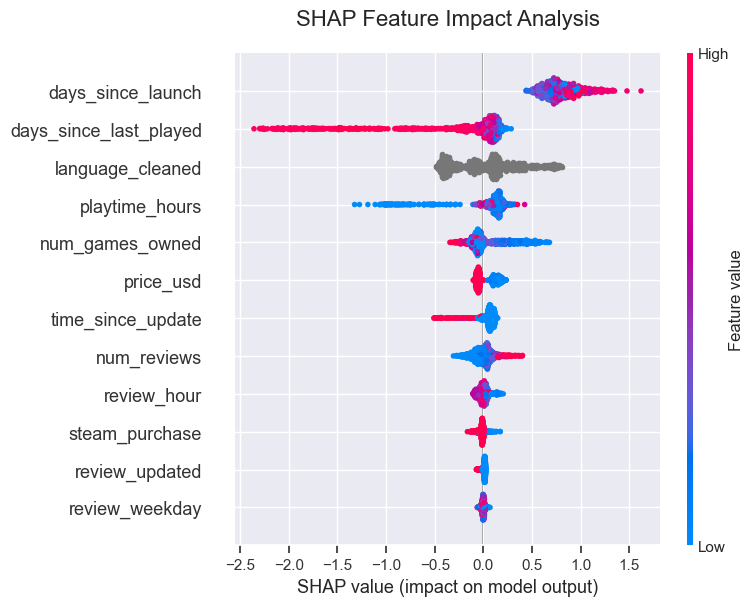

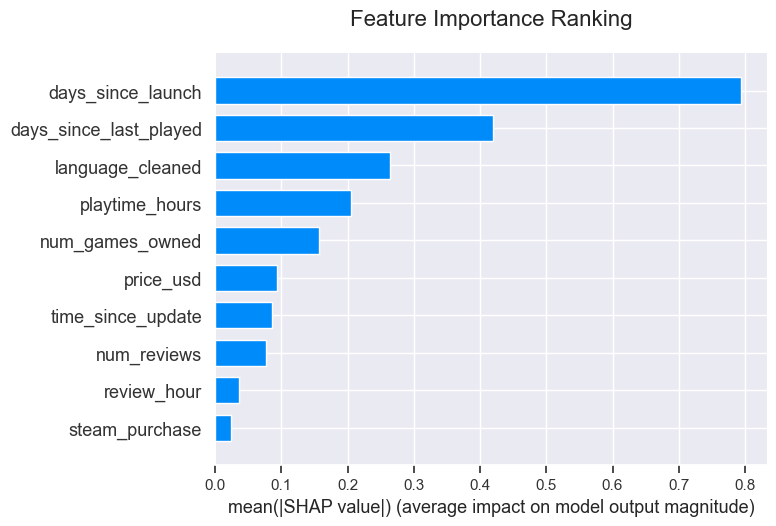

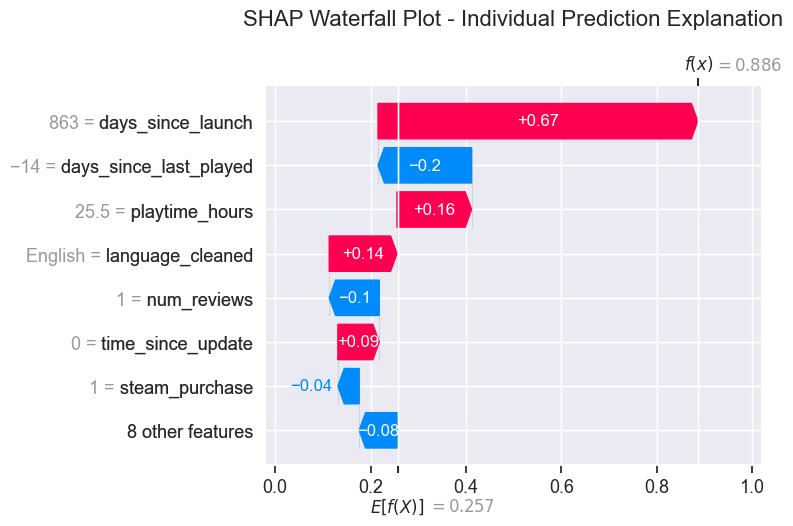

In [ ]:
# SHAP Analysis - Generate Key Visualizations
print("🔍 SHAP ANALYSIS: Generating Visualizations for Business Insights")
print("=" * 50)

# Generate SHAP visualizations
sample_data = shap_sample

# 1. Summary plot showing feature importance and impact direction
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, 
                  features=sample_data, 
                  feature_names=X_test.columns.tolist(),
                  show=False,
                  max_display=12)
plt.title('SHAP Feature Impact Analysis', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Feature importance ranking
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, 
                  features=sample_data,
                  feature_names=X_test.columns.tolist(),
                  show=False,
                  max_display=10,
                  plot_type="bar")
plt.title('Feature Importance Ranking', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('shap_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Create waterfall plot for business interpretation
# Select a representative sample (e.g., first sample or a specific interesting case)
sample_idx = 0  # Use first sample, or choose a specific index for interesting cases

plt.figure(figsize=(12, 8))
# Create a proper SHAP Explanation object for waterfall plot
explanation = shap.Explanation(
    values=shap_values[sample_idx], 
    base_values=explainer.expected_value, 
    data=sample_data.iloc[sample_idx].values,
    feature_names=X_test.columns.tolist()
)

# Use the correct waterfall plot syntax
shap.waterfall_plot(explanation, max_display=8, show=False)
plt.title('SHAP Waterfall Plot - Individual Prediction Explanation', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('shap_waterfall.png', dpi=300, bbox_inches='tight')
plt.show()


In [75]:
# 3. Calculate feature importance for saving (detailed analysis in section 8.1)
feature_importance = pd.DataFrame(
    np.abs(shap_values).mean(0),
    index=X_test.columns,
    columns=['SHAP_Importance']
).sort_values('SHAP_Importance', ascending=False)

total_importance = feature_importance['SHAP_Importance'].sum()
feature_importance['Percentage'] = feature_importance['SHAP_Importance'] / total_importance
feature_importance

,SHAP_Importance,Percentage
days_since_launch,0.793258,0.360800
days_since_last_played,0.418899,0.190529
language_cleaned,0.264695,0.120392
playtime_hours,0.205145,0.093306
num_games_owned,0.157115,0.071461
price_usd,0.093614,0.042579
time_since_update,0.085344,0.038817
num_reviews,0.077160,0.035095
review_hour,0.035535,0.016163
steam_purchase,0.024195,0.011005


## 8.1. SHAP Business Insights

### 💡 **Key Business Insights**

Based on SHAP feature importance analysis, several critical patterns emerge with clear business actionability. The percentages below reflect each feature’s **share of total model impact** (mean absolute SHAP value normalized to sum to 100%).


#### **📅 POST-LAUNCH STRATEGY** (**36.1%** of Feature Importance)
**`days_since_launch`** dominates with overwhelming importance, confirming that time since launch strongly affects satisfaction. This validates the critical importance of sustained post-launch content and improvements.

#### 🕹️ RECENT ENGAGEMENT (**19.1%**)
**`days_since_last_played`** shows that recent play activity strongly correlates with positive reviews—highly predictive but partially reflects self-selection (satisfied players play more).

#### **🌍 LOCALIZATION PRIORITY** (**12.0%**)
**`language_cleaned`** shows significant regional differences, suggesting prioritization of region-specific content and cultural adaptation as a key growth strategy.

#### 🎮 PLAYER PROFILE DEPTH (**7.1%**)
**`num_games_owned`** suggests that “core gamers” respond differently; targeting these player segments could help tailor offerings.

#### 💰 PRICING CONTEXT (**4.3%**)
**`price_when_reviewed`** shows some correlation with positive reviews, but the temporal mismatch means this is more about "price when satisfied/dissatisfied enough to review" rather than actual purchase price. Use with caution.

#### **⚠️ SELECTION BIAS ALERT** (High Predictive but Low Actionability)
Engagement features (`playtime_hours`, `days_since_last_played`) have strong predictive power but represent selection bias - players who enjoy the game play more AND review positively.

---

**How the percentages are calculated:**  
Each value is computed as `mean(|SHAP value|) for the feature / sum(mean(|SHAP value|) for all features) * 100`.

## 9. Save Results

Let's save our model and important artifacts for future use.

In [76]:
# Save the model
model_final.save_model('xgb_bf2042.json')
print("Model saved as 'xgb_bf2042.json'")

# Save feature importance data from SHAP analysis
feature_importance.to_csv('feature_importance.csv')
print("Feature importance saved as 'feature_importance.csv'")

# All plots have already been saved in earlier cells:
print("SHAP summary plot saved as 'shap_summary.png'")
print("Confusion matrix saved as 'confusion_matrix.png'")
print("ROC and Precision-Recall curves saved as 'model_performance_curves.png'")
print("SHAP feature importance plot saved as 'shap_importance.png'")
print("SHAP waterfall plot saved as 'shap_waterfall.png'")

# Optuna study object already saved as 'optuna_study_bf2042.pkl'
print("Optuna study saved as 'optuna_study_bf2042.pkl'")

Model saved as 'xgb_bf2042.json'
Feature importance saved as 'feature_importance.csv'
SHAP summary plot saved as 'shap_summary.png'
Confusion matrix saved as 'confusion_matrix.png'
ROC and Precision-Recall curves saved as 'model_performance_curves.png'
SHAP feature importance plot saved as 'shap_importance.png'
SHAP waterfall plot saved as 'shap_waterfall.png'
Optuna study saved as 'optuna_study_bf2042.pkl'


🎮 GAMING LIFECYCLE TRANSFORMATION ANALYSIS
📊 SATISFACTION EVOLUTION:
Early Period (0-90 days):     28.2% positive
Late Period (365+ days):      59.8% positive
Overall Average:              46.5% positive
Improvement:                  +31.6 percentage points


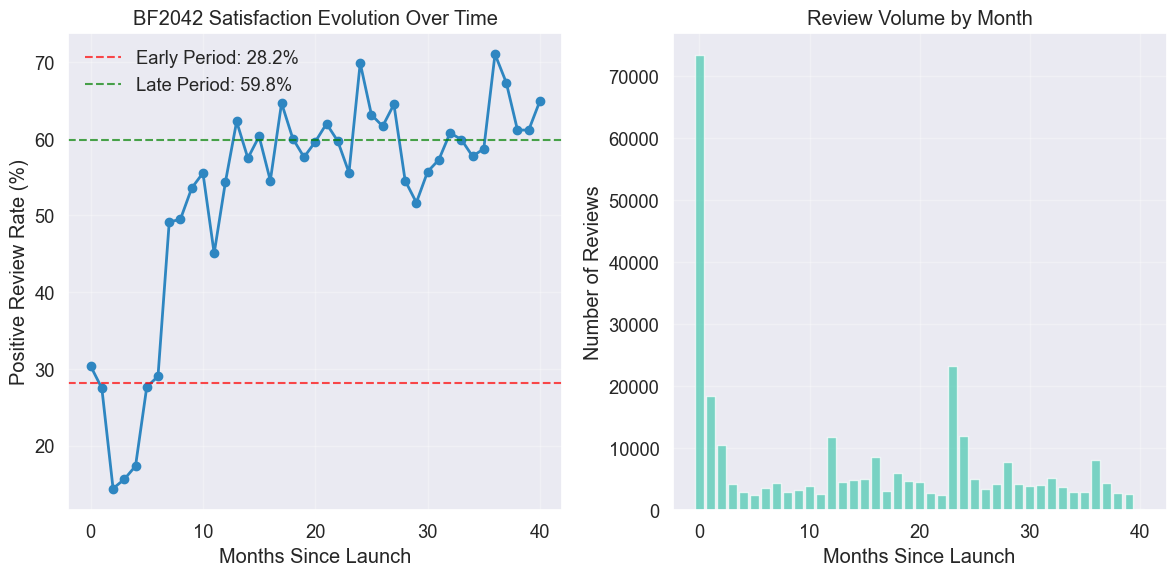


📈 STATISTICAL VALIDATION:
Early period sample size:     102,557 reviews
Late period sample size:      159,134 reviews
Chi-square test p-value:      0.00e+00
Result: Statistically significant improvement

✅ CONCLUSION: BF2042 demonstrates clear gaming lifecycle transformation
   from 28.2% → 59.8% positive reviews


In [77]:
# Demonstrate Gaming Lifecycle Transformation
print("🎮 GAMING LIFECYCLE TRANSFORMATION ANALYSIS")
print("=" * 60)

# Create temporal bins to show satisfaction evolution
merged_df['days_since_launch'] = (merged_df['timestamp_updated'] - pd.Timestamp('2021-11-19')).dt.days

# Define time periods
early_period = merged_df['days_since_launch'] <= 90  # First 3 months
late_period = merged_df['days_since_launch'] > 365   # After 1 year

# Calculate satisfaction rates
early_satisfaction = merged_df[early_period]['voted_up'].mean()
late_satisfaction = merged_df[late_period]['voted_up'].mean()
overall_satisfaction = merged_df['voted_up'].mean()

print(f"📊 SATISFACTION EVOLUTION:")
print(f"Early Period (0-90 days):     {early_satisfaction:.1%} positive")
print(f"Late Period (365+ days):      {late_satisfaction:.1%} positive") 
print(f"Overall Average:              {overall_satisfaction:.1%} positive")
print(f"Improvement:                  +{(late_satisfaction - early_satisfaction)*100:.1f} percentage points")

# Visualize the transformation
plt.figure(figsize=(12, 6))

# Create monthly satisfaction rates
merged_df['month_since_launch'] = (merged_df['days_since_launch'] / 30).astype(int)
monthly_satisfaction = merged_df.groupby('month_since_launch')['voted_up'].agg(['mean', 'count']).reset_index()

# Filter months with sufficient data (at least 50 reviews)
monthly_satisfaction = monthly_satisfaction[monthly_satisfaction['count'] >= 50]

plt.subplot(1, 2, 1)
plt.plot(monthly_satisfaction['month_since_launch'], monthly_satisfaction['mean'] * 100, 
         marker='o', linewidth=2, markersize=6, color='#2E86C1')
plt.axhline(y=early_satisfaction*100, color='red', linestyle='--', alpha=0.7, 
           label=f'Early Period: {early_satisfaction:.1%}')
plt.axhline(y=late_satisfaction*100, color='green', linestyle='--', alpha=0.7,
           label=f'Late Period: {late_satisfaction:.1%}')
plt.xlabel('Months Since Launch')
plt.ylabel('Positive Review Rate (%)')
plt.title('BF2042 Satisfaction Evolution Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

# Show sample sizes
plt.subplot(1, 2, 2)
plt.bar(monthly_satisfaction['month_since_launch'], monthly_satisfaction['count'], 
        alpha=0.7, color='#48C9B0')
plt.xlabel('Months Since Launch')
plt.ylabel('Number of Reviews')
plt.title('Review Volume by Month')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gaming_lifecycle_transformation.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical significance test
from scipy.stats import chi2_contingency

# Create contingency table
early_positive = merged_df[early_period]['voted_up'].sum()
early_total = len(merged_df[early_period])
late_positive = merged_df[late_period]['voted_up'].sum() 
late_total = len(merged_df[late_period])

contingency_table = [
    [early_positive, early_total - early_positive],
    [late_positive, late_total - late_positive]
]

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\n📈 STATISTICAL VALIDATION:")
print(f"Early period sample size:     {early_total:,} reviews")
print(f"Late period sample size:      {late_total:,} reviews")
print(f"Chi-square test p-value:      {p_value:.2e}")
print(f"Result: {'Statistically significant' if p_value < 0.001 else 'Not significant'} improvement")

print(f"\n✅ CONCLUSION: BF2042 demonstrates clear gaming lifecycle transformation")
print(f"   from {early_satisfaction:.1%} → {late_satisfaction:.1%} positive reviews")

# 🎯 **CONCLUSION**
---

## 🎮 **Key Discovery**

**Battlefield 2042's Transformation**:
- **Gaming Transformation**: 28.2% → 59.8% positive reviews (p < 0.001)
- **SHAP Analysis**: `days_since_launch` dominates (36.1% importance) - confirms temporal patterns

**XGBoost Model Insights**: 
1. **Test Set AUC: 0.77** - Strong predictive performance
2. **Post-Launch Content Strategy** - Highest feature importance validates sustained development investment
3. **Regional Localization** - Language features show significant satisfaction variance across markets
4. **Player Segmentation** - Gaming profile features (num_games_owned) inform targeted experiences

--- 
### **Model Limitations & Bias Documentation**
- **Selection Bias**: Engagement metrics (playtime, recency) predict satisfaction but represent correlation, not causation
- **Temporal Data Constraints**: Price-at-review vs. price-at-purchase mismatch limits pricing strategy insights
- **Platform Specificity**: Steam-only analysis may not represent EA's full ecosystem

---

## 🚀 **Next Steps**

1. **Implement temporal monitoring** using the dominant days_since_launch pattern for real-time satisfaction tracking
2. **Develop regional content strategy** leveraging SHAP-identified language-based satisfaction differences  
3. **Extend methodology to EA portfolio** for cross-game lifecycle pattern analysis
4. **Address selection bias** by incorporating external engagement metrics independent of satisfaction

---

## ✅ **Bottom Line**

**Production-Ready Analytics with Documented Limitations**: XGBoost model achieves strong performance (0.77 AUC on temporal test split) while SHAP analysis reveals the dominant importance of temporal patterns and regional differences for strategic decision-making. The temporal analysis quantifies BF2042's dramatic recovery (+31.6 percentage points), providing a robust framework for understanding gaming lifecycle patterns.

**Technical Achievement**: Bias-aware modeling that distinguishes between predictive power and strategic actionability, with clear documentation of model limitations and appropriate use cases.